# Hand-written digits classification

* [Task description](#Task-description)
* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Selection of hyperparameters](#Selection-of-hyperparameters)
* [Training](#Training)
* [Inference](#Inference)
* [Model evaluation](#Model-evaluation)
* [Operating time](#Operating-time)
* [Criticism](#Criticism)
* [Summary](#Summary)
* [Proposals for the improvement and further development](#Proposals-for-the-improvement-and-further-development)

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.join("..", ".."))
from batchflow import B, F, V, C, R, Pipeline
from batchflow.opensets import MNIST
from batchflow.models.tf import TFModel
from batchflow.research import Research, Results

from src import show_samples, class_histogram, show_loss, show_histogram, class_precision

## Task description
Classification of hand-written digits images


## Dataset

For training and model performance assessment we use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/).

It contains grayscale images (28x28 pixels) and consists of two parts: train (60k items) and test (10k items).

Each part comprises:
* an array of images of size 28х28 pixels in greyscale
* an array of labels corresponding to a digit on each image.

Dataset loading:

In [2]:
dataset = MNIST(bar=True)

100%|██████████| 8/8 [00:01<00:00,  1.90it/s]


Examples of dataset items:

In [3]:
train = dataset.train.next_batch(len(dataset.train))
test = dataset.test.next_batch(len(dataset.test))

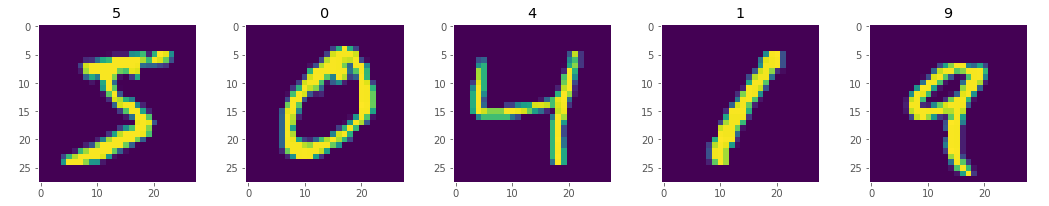

In [4]:
show_samples(train.to_array().images[:5, :, :, 0], labels=train.labels[:5])

Distribution of a number of examples for each class in train and test set.
As we can see classes are quietly balanced.

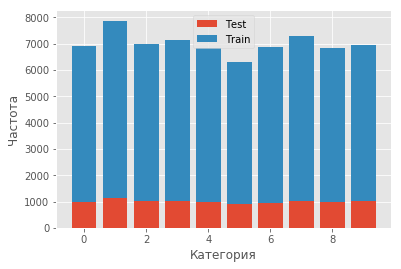

In [5]:
class_histogram(train, test)

Data reliability is proved by multiple usages in research e.g. 
* https://arxiv.org/pdf/1704.07709
* https://arxiv.org/abs/1302.4389
* https://arxiv.org/abs/1312.4400.

## Model architecture

We use a convolutional neural network consisting of 3 identical blocks.
The network architecture can be described by layout `cpna cpna cpna Pf`, where letters correspond to the following layers:
* `с` - 2d convolution
* `p` - max pooling
* `n` - batch normalisation
* `a` - activation
* `P` - global average pooling
* `f` - dense

Convolutional layer parameters `c`:
* ```filters```= 64 * 2**i, where i - block number, i=0, 1, 2.
* ```kernel_size``` = 3
* ```strides``` = 2
* ```padding``` = 'same'
* ```data_format``` = 'channels_last'
* ```activation``` = `None`

Pooling layer parameters `p`:
* ```pool_size``` = 2
* ```pool_strides``` = 1.

Activation layer parameters `a`:
* `activation` = `tf.nn.relu`

Dense layer parameters `dense`:
* `filters` = 10
* `activation` = `None`

Model description config:

In [6]:
NUM_CLASSES = 10

model_config = {
    'inputs/images/shape': B('image_shape'),
    'inputs/labels/classes': NUM_CLASSES,
    'initial_block/inputs': 'images',
    'body': dict(layout='cpna cpna cpna', filters=[64, 128, 256],
                 strides=2, pool_strides=1, kernel_size=3),
    'head': dict(layout='Pf', units=NUM_CLASSES),
    'loss': 'crossentropy',
    'optimizer': ('Momentum', {'use_nesterov': True, 'learning_rate': 0.01, 'momentum': 0.5}),
    'output': ['proba']}

## Selection of hyperparameters

The choice of the architecture (number of blocks and number of filters in convolutional layers) is motivated by the [research](parameters_estimation.ipynb).

Other parameters such as an activation function and a block layout are chosen due to the common standards. 

## Training

The model is trained using stochastic gradient descent. On each iteration
* mini-batch data is loaded
* the model weights are updated 

An algorithm of the weights update (optimizer) is the Nesterov momentum with following parameters:
* ```learning_rate``` = 0.01
* ```mu``` = 0.5

The choice of optimizer hyperparameters is motivated by the [research](../aux/parameters_extimation/optimizer_search.ipynb), as for they show the best convergence.

Loss - cross-entropy.

Dataset bypass:
* ```batch_size``` = 64
* ```n_epochs``` = 1.

Training pipeline:

In [7]:
train_template = (Pipeline()
                  .init_variable('loss_history', init_on_each_run=list)
                  .init_model('dynamic', TFModel, 'mnist_model', config=model_config)
                  .to_array()
                  .train_model('mnist_model', fetches='loss', images=B('images'), labels=B('labels'), 
                               save_to=V('loss_history', mode='a'))
                  .run_later(64, shuffle=True, n_epochs=1, drop_last=True, bar=True))

Execute training

In [8]:
train_pipeline = (train_template << dataset.train).run()

100%|██████████| 937/937 [01:21<00:00, 11.56it/s]


The loss function vs number of iterations:

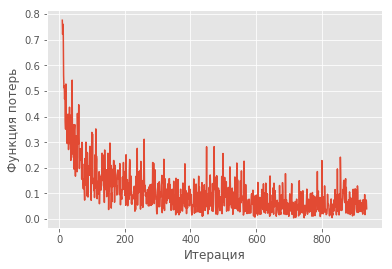

In [9]:
show_loss(train_pipeline.get_variable('loss_history'), skip=10)

## Inference

Prediction pipeline:

In [10]:
predict_template = (Pipeline()
                    .import_model('mnist_model', train_pipeline)
                    .init_variable("predictions", init_on_each_run=list)
                    .to_array()
                    .predict_model('mnist_model', fetches='proba', images=B('images'),
                                   save_to=V('predictions', mode="e")))

Execute prediction pipeline

In [11]:
predict_pipeline = (predict_template << dataset.test).run(64, shuffle=False, n_epochs=1, drop_last=False, bar=True)

 99%|█████████▉| 156/157 [00:02<00:00, 54.28it/s]


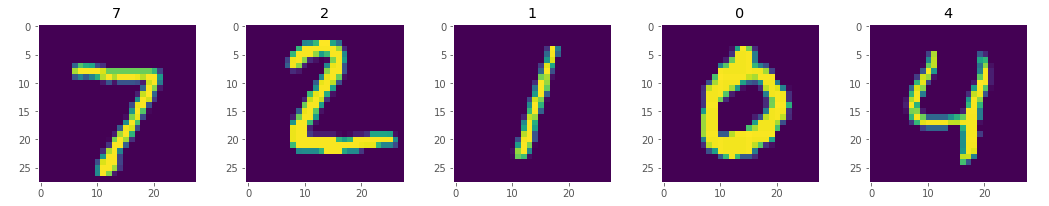

In [12]:
size = 5
y_pred = predict_pipeline.get_variable('predictions')
show_samples(test.to_array().images[:size, :, :, 0], labels=np.argmax(y_pred[:size], axis=1))

## Model evaluation

Quality metric, in this case, is ```accuracy``` on the test set.

Metric evaluation pipeline:

In [13]:
test_template = (Pipeline()
                 .import_model('mnist_model', train_pipeline)
                 .init_variable('predictions', init_on_each_run=list)
                 .init_variable('metrics', init_on_each_run=None)
                 .to_array()
                 .predict_model('mnist_model', fetches='proba', images=B('images'),
                                save_to=V('predictions'))
                 .gather_metrics('class', targets=B('labels'), predictions=V('predictions'),
                                 fmt='proba', axis=-1, save_to=V('metrics', mode='u'))
                 .run_later(64, shuffle=False, n_epochs=1, drop_last=True, bar=True))

In [14]:
test_pipeline = (test_template << dataset.test).run()

100%|██████████| 156/156 [00:03<00:00, 47.29it/s]


In [15]:
metrics = test_pipeline.get_variable('metrics')
print("Accuracy: %.3f" % metrics.evaluate('accuracy'))

Accuracy: 0.983


```confusion_matrix``` on 10 classes (rows and columns are numbered from 0 до 9 corresponding to the numbers on
the images):

In [16]:
print(metrics.confusion_matrix)

[[ 971    0    2    0    0    1    8    0    2    2]
 [   0 1127    1    0    1    0    2    2    0    3]
 [   2    1 1012    1    2    0    0    4    0    1]
 [   0    2    3  999    0   15    0    2    3    5]
 [   0    0    2    0  960    0    2    0    2    7]
 [   1    1    0    1    0  869    6    0    3    5]
 [   0    0    1    0    1    2  935    0    0    1]
 [   3    2    5    5    3    3    0 1018    3   12]
 [   2    0    2    2    7    0    3    1  957    4]
 [   0    0    2    0    6    0    0    0    3  968]]


 `Precision` Histogram for each class:

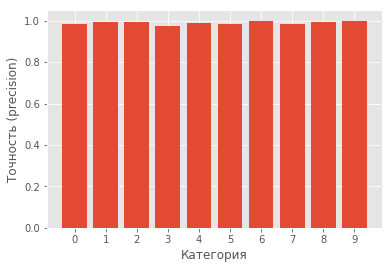

In [17]:
class_precision(metrics.confusion_matrix)

For model performance assessment an [experiment](./model_evaluation.ipynb) was conducted on 20 model training launches from  scratch.

Research results loading and a distribution for `accuracy`:

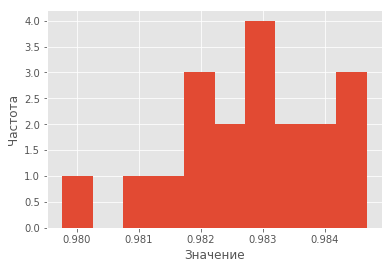

The average (median) accuracy is 0.983


In [18]:
if os.path.exists('model_evaluation'):
    df = Results(path='model_evaluation').load()
    values = df[df['name'] == 'test']['metrics'].apply(lambda x: x.evaluate('accuracy')).values

    show_histogram(values)
    print('The average (median) accuracy is %.3f' % np.median(values))
else:
    print("Run model evaluation notebook first to see accuracy histogram.")

## Operating time

Device: CPU i7.

One train step on batch size 64 takes 200 ms. Training time is 32 s.

One image inference takes 3 ms, for batch size 64 - 44 ms.

## Criticism

To identify weak spots of the model we performed model prediction on the shifted images.
To do so we added an image shift step to the prediction pipeline. An image is shifted on a random number of pixels from the uniform distribution in [-5, 5]

In [19]:
criticism_pipeline_template = (
  Pipeline()
    .import_model("mnist_model", train_pipeline)
    .init_variable("predictions")
    .init_variable("metrics", init_on_each_run=None)
    .shift((R("randint", -5, 5), R("randint", -5, 5)))
    .to_array()
    .predict_model("mnist_model", fetches="predictions", save_to=V("predictions"),
                   feed_dict={"images": B("images")})
    .gather_metrics("class", targets=B("labels"), predictions=V("predictions"),
                    fmt="logits", axis=-1, save_to=V("metrics", mode="u"))
    .run_later(batch_size=64, n_epochs=1, drop_last=False, bar=True)
)

Run criticism pipeline

In [20]:
criticism_pipeline = (dataset.test >> criticism_pipeline_template).run()

 99%|█████████▉| 156/157 [00:03<00:00, 49.04it/s]


Compute `accuracy`

In [21]:
print("Accuracy: %.3f" % criticism_pipeline.get_variable("metrics").evaluate("accuracy"))

Accuracy: 0.747


Accuracy decreased by 20%, which means the model is sensitive to a shift.

## Summary

The model classifies images of hand-written digits (grayscale, size 28х28) with an average (median) accuracy of 98.5%.


## Proposals for the improvement and further development

To improve classification (e.g. make it more robast to the image shift) we suggest to include augmentations to the training pipeline.